# Methods to Measure Properties After Phase-Folding
- goals
    - measure amplitude, width, skew, kurtosis of folded period
    - quantify error
        - can start finding error on peak width --> how does that change shape
        - bootstrapping
        - different number of phase bins (but help this by ultimately holding this constant across sources)
    - change in features as function of time (e.g. by the year)
        - this will help relate it to certain features or mean magnitude, for e.g.
        
        
TO DOs
- finalize metrics
    - but can add all of them to auto analysis; can always pick and choose among them
        - decide on symm avg
        - all results already shown in this notebook, although some periods different than those in auto
    - finalize analysis of effect of # bins
        - but not too much of an issue to just use constant bins in other notebook
        - detrending window doesn't seem like much of a concern, as long as it's not too low
    - **add something about error (e.g. max standard error)**
    - propagate/report error on each parameter
- examples for analyzing changes in these parameters over time
    - try by the year, or OII, OIII, OIV
    
    

In [1]:
#imports
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

#tables (for pulsating sources)
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
summ = pd.read_csv('summtab.csv') 

# Source 22
- initial detrending spline window of 200

established period: 90.5


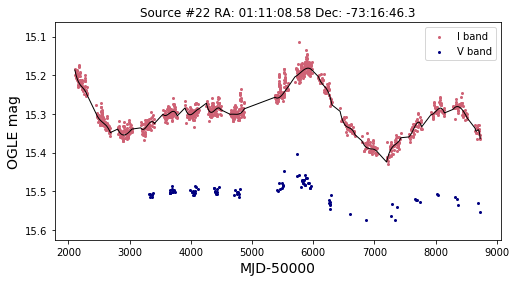

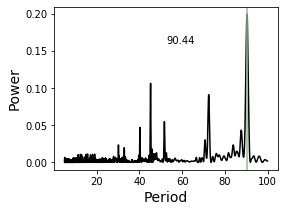

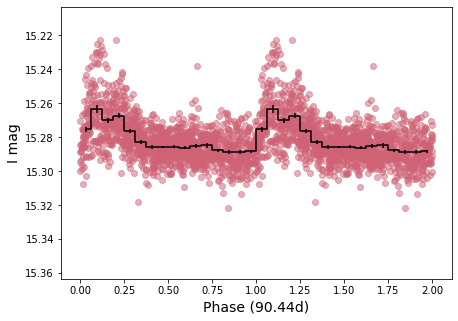

In [2]:
iband22,vband,bp22 = o.splinesearch(22,cross,full,minp=5,maxp=100,window=200,btol=50,phase=True,color=pink,ylim=.08)

need both difference and which ones comes first
- min first shows it declines to max
- max first shows it then goes up to min

difference between maximum point in max phase bin and minimum point in mininimum phase bin
- or do both max and min in each

In [3]:
def symm(mid,avg,err,pdict,pbins=16,ylim=.01,square=False,plot=False):
    '''Fold over maximum; subtract and return sum of squares
    To do:  add propagation of standard error
            option to divide by some number (max in the bin? amplitude?)'''
    roll = int(pbins/2) - int(float(pdict['phase min']*pbins-0.5))
    ravg = np.roll(avg,roll)
    rerr = np.roll(err,roll)
#     mid,avg,err = o.phasestep(iband,bp,pbins,det=True,med=False,double=True,color='black',err=True,retall=True,epoch=epoch,divide=True,label='')
    sums = []
    st = pbins - 1
    if not plot: plt.close()
    for i in range(int(pbins/2)-1):
        sums.append(ravg[i]-ravg[st-i])
        if plot:
#             plt.scatter(mid[i],avg[i],color=pink)
            plt.step(mid,ravg,color='black',where='mid')
            plt.errorbar(mid,ravg,yerr=rerr,ls='none',color='grey',alpha=0.5)
            maxa,mina = np.nanmax(avg),np.nanmin(avg)
            plt.ylim(maxa+.01,mina-.01)
            plt.scatter(mid[i],ravg[st-i],color=pink)
            plt.scatter(mid[st-i],ravg[st-i],color='darkseagreen')
    sums = np.array(sums)
    if square: 
        pdict['symm sum'] = np.sum(sums**2)
        return np.sum(sums**2)
    else: 
        #'sum' but really an mean difference when folded in half around peak
        pdict['symm sum'] = np.abs(np.mean(sums))
        return np.sum(sums)

In [4]:
#function for all steps
def phase_dict(iband,pd,pbins,det=True,retstep=False,plotsymm=True,close=False):
    '''phase-fold all data and add amp, phase diff, phase max, phase min, shape, and diff sum to dictionary
    note: max and min are in mags, so phase max is phase bin # of faintest bin
    to do:  decide whether to convert to increasing from zero right away
            integrate symm into this function'''
    pdict = {}
    mid,avg,err = o.phasestep(iband,pd,pbins,det=det,med=False,double=True,color='black',err=True,retall=True,epoch=0,divide=True,label='')
    if close: plt.close()
    #put in period for global analysis
    pdict['period'] = pd
    #calculate range
    pdict['amp'] = np.max(avg) - np.min(avg)
    #phase bin # of max and min bins
    maxp = np.where(avg == np.max(avg))[0][0] 
    minp = np.where(avg == np.min(avg))[0][0] 
    pdict['phase diff'] = (maxp-minp)/pbins
    if pdict['phase diff'] < 0:
        pdict['phase diff'] = 1+pdict['phase diff']
    pdict['phase max'] = mid[avg==np.max(avg)][0]
    pdict['phase min'] = mid[avg==np.min(avg)][0]
    #case 1 for FRED
    if pdict['phase diff']>0.5 and maxp>minp:
        pdict['shape'] = 'FRED'
    #case 2
    elif pdict['phase diff']<0.5 and maxp<minp:
        pdict['shape'] = 'FRED'
    else:
        #other shape: sine or symm?
        pdict['shape'] = 'not FRED'
    #redefine to use increasing numbers, start at 0 (decide whether to do this right away)
    diff = np.max(avg) - avg
    pdict['diff mean'] = np.mean(diff) #can compare mean to amp etc.; not dependent on I mag
    pdict['mean'] = np.mean(avg) #allows for luminosity correlations
    #whether diff or original avg used in skew just flips sign; kurtosis the same either way
#     print('remember skew flipped b/c of magnitudes')
#     print('so positive skew has asymmetry toward (more) low values = bright values')
    pdict['skew'] = st.skew(avg)
    pdict['kurtosis'] = st.kurtosis(avg)
    #adds symmetry sum to dictionary
    plt.figure(figsize=(5,4))
    summ = symm(mid,avg,err,pdict,pbins=pbins,plot=plotsymm)
    if retstep:
        return mid,avg,err,pdict
    else: return pdict

{'period': <Quantity 90.44088625>,
 'amp': 0.028003135485061392,
 'phase diff': 0.8333333333333334,
 'phase max': 0.9166666666666667,
 'phase min': 0.08333333333333334,
 'shape': 'FRED',
 'diff mean': 0.008419057402908218,
 'mean': 15.281258738002627,
 'skew': -1.07714645663876,
 'kurtosis': -0.3182155711411192,
 'symm sum': 0.008358182984879876}

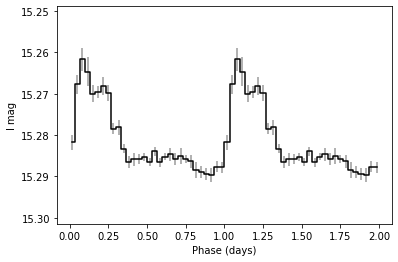

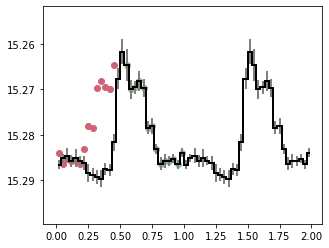

In [5]:
mid,avg,err,dict22 = phase_dict(iband22,bp22,30,retstep=True)
dict22

if positive, phase diff should be > 0.5 for FRED; if negative it should be < .05
- so simplified by adding 1 if it's negative

### effect of changing phase bins (for this source)

In [6]:
dict22

{'period': <Quantity 90.44088625>,
 'amp': 0.028003135485061392,
 'phase diff': 0.8333333333333334,
 'phase max': 0.9166666666666667,
 'phase min': 0.08333333333333334,
 'shape': 'FRED',
 'diff mean': 0.008419057402908218,
 'mean': 15.281258738002627,
 'skew': -1.07714645663876,
 'kurtosis': -0.3182155711411192,
 'symm sum': 0.008358182984879876}

In [7]:
bindf = pd.DataFrame(columns=['bins','amp','phase diff','phase max','phase min','shape',
                             'diff sum','skew','kurtosis','symm sum'])

In [8]:
list(dict22.keys())

['period',
 'amp',
 'phase diff',
 'phase max',
 'phase min',
 'shape',
 'diff mean',
 'mean',
 'skew',
 'kurtosis',
 'symm sum']

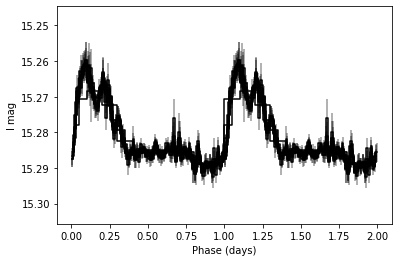

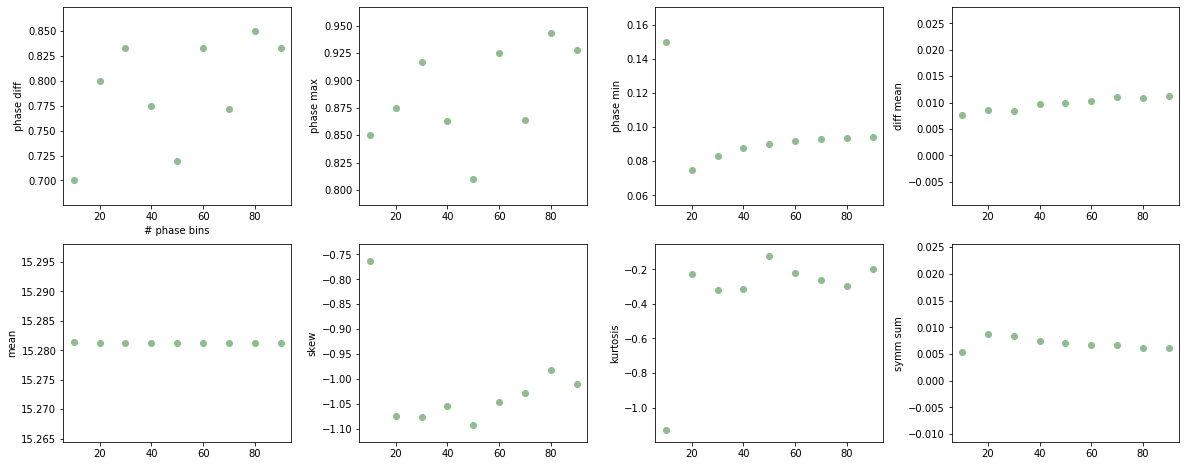

In [9]:
def test_bins(iband,bp,bins=np.arange(10,100,10),plot=True):
    bindf = pd.DataFrame(columns=['bins','amp','phase diff','phase max','phase min','shape',
                             'diff mean','mean','skew','kurtosis','symm sum'])
    bindf['bins'] = bins
    for b in bins:
        #temporary dictionary
        tdict = phase_dict(iband,bp,b,plotsymm=False)
        for d in list(tdict.keys()):
            row = bindf[bindf['bins']==b]
            row[d] = tdict[d]
            bindf[bindf['bins']==b] = row
    if plot:
        fig = plt.figure(figsize=(20,8))
        c = 1
        for r in ['phase diff','phase max','phase min','diff mean','mean','skew','kurtosis','symm sum']:
            ax = fig.add_subplot(2,4,c)
            ax.scatter(bindf['bins'],bindf[r],color='darkseagreen')
            ax.set_ylabel(r)
            if c==1:
                ax.set_xlabel('# phase bins')
            c+=1
        plt.subplots_adjust(wspace=0.3)

    return bindf
bindf = test_bins(iband22,bp22)

In [10]:
bindf

,bins,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum
0,10,0.020535,0.7,0.85,0.15,FRED,0.00756971,15.2813,-0.762573,-1.1306,0.00542219
1,20,0.027116,0.8,0.875,0.075,FRED,0.00868575,15.2813,-1.07565,-0.228976,0.00869974
2,30,0.0280031,0.833333,0.916667,0.0833333,FRED,0.00841906,15.2813,-1.07715,-0.318216,0.00835818
3,40,0.02998,0.775,0.8625,0.0875,FRED,0.00981894,15.2813,-1.05478,-0.312724,0.00748589
4,50,0.0306815,0.72,0.81,0.09,FRED,0.00985995,15.2813,-1.09348,-0.121506,0.00700653
5,60,0.0299214,0.833333,0.925,0.0916667,FRED,0.0102488,15.2813,-1.04647,-0.223706,0.00668301
6,70,0.0315995,0.771429,0.864286,0.0928571,FRED,0.011052,15.2813,-1.02894,-0.261764,0.00660975
7,80,0.0324149,0.85,0.94375,0.09375,FRED,0.0109218,15.2812,-0.981849,-0.298209,0.0060624
8,90,0.0327919,0.833333,0.927778,0.0944444,FRED,0.0112192,15.2812,-1.01005,-0.199985,0.00606642


### effect of changing detrending window (for this source)

established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5
established period: 90.5


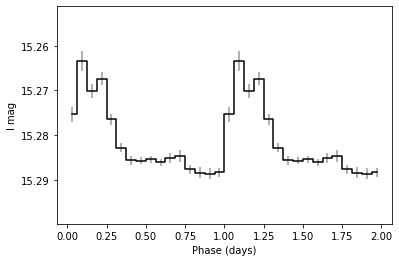

In [11]:
reload(o)
windows = np.arange(50,1000,100)
wdf = pd.DataFrame(columns=['window','amp','phase diff','phase max','phase min','shape',
                             'diff mean','mean','skew','kurtosis','symm sum'])
wdf['window'] = windows
for w in windows:
    #LC, detrend, and spline search
    iband,vband,bp = o.splinesearch(22,cross,full,minp=5,maxp=100,window=w,btol=50,phase=True,color=pink,ylim=.08,close=True)
    plt.close()
    #analyze phase-folded data with best period, yielding dictionary
    tdict = phase_dict(iband,bp,16,plotsymm=False)
    for d in list(tdict.keys()):
        row = wdf[wdf['window']==w]
        row[d] = tdict[d]
        wdf[wdf['window']==w] = row

In [12]:
wdf

,window,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum
0,50,0.0232523,0.8125,0.90625,0.09375,FRED,0.00640198,15.2814,-1.18916,0.134175,0.00544487
1,150,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
2,250,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
3,350,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
4,450,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
5,550,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
6,650,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
7,750,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
8,850,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644
9,950,0.0252353,0.8125,0.90625,0.09375,FRED,0.00731834,15.2813,-1.06766,-0.276826,0.00789644


- luckily, features essentially invariant under detrending window (though this should be tested on a couple other sources
- however, there are a couple changes with the lowest detrending window, which is too low for use anyway
    - as shown in plot above, even that one only had slight changes in shape
    - always inspect spline briefly and adjust btol as needed

### effect of changing period (using period error)

# Source : 17 symmetrical shape
- which parameters help distinguish between the shapes?
    - tough define FRED cutoff -- this is good example
    - perhaps better to just use phase diff/continuum

established period: 36.43182


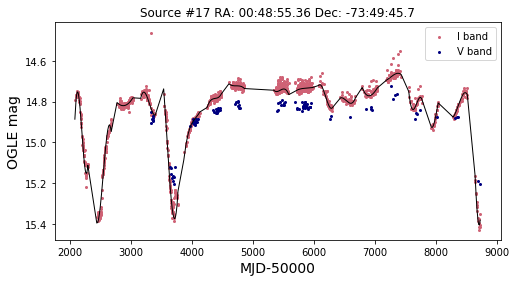

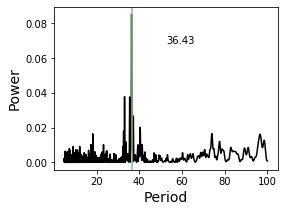

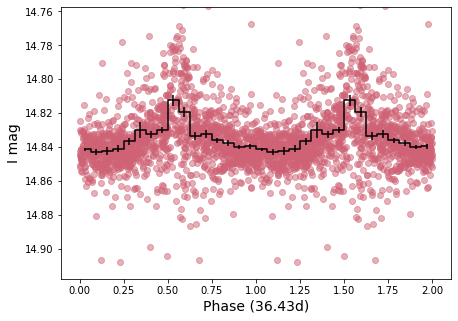

In [13]:
iband17,vband,bp17 = o.splinesearch(17,cross,full,minp=5,maxp=100,window=200,btol=50,phase=True,color=pink,ylim=.08)

{'period': <Quantity 36.42639701>,
 'amp': 0.03030438044407724,
 'phase diff': 0.5625,
 'phase max': 0.09375,
 'phase min': 0.53125,
 'shape': 'not FRED',
 'diff mean': 0.00865141997997898,
 'mean': 14.834129014702366,
 'skew': -1.3242284673915747,
 'kurtosis': 1.113244785933814,
 'symm sum': 0.003981398481785549}

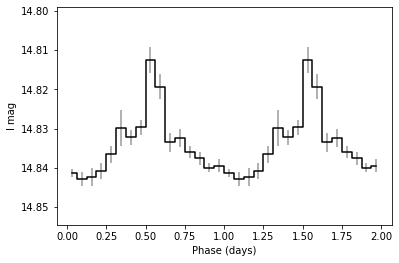

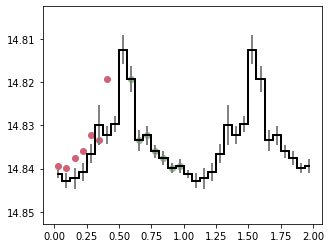

In [14]:
dict17 = phase_dict(iband17,bp17,16)
dict17
#change to dividing phase by pbins to be independent of #pbins

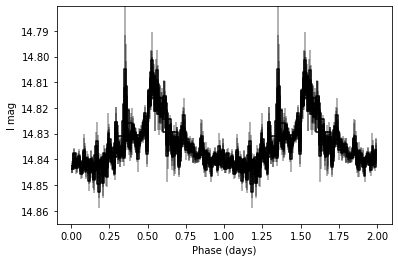

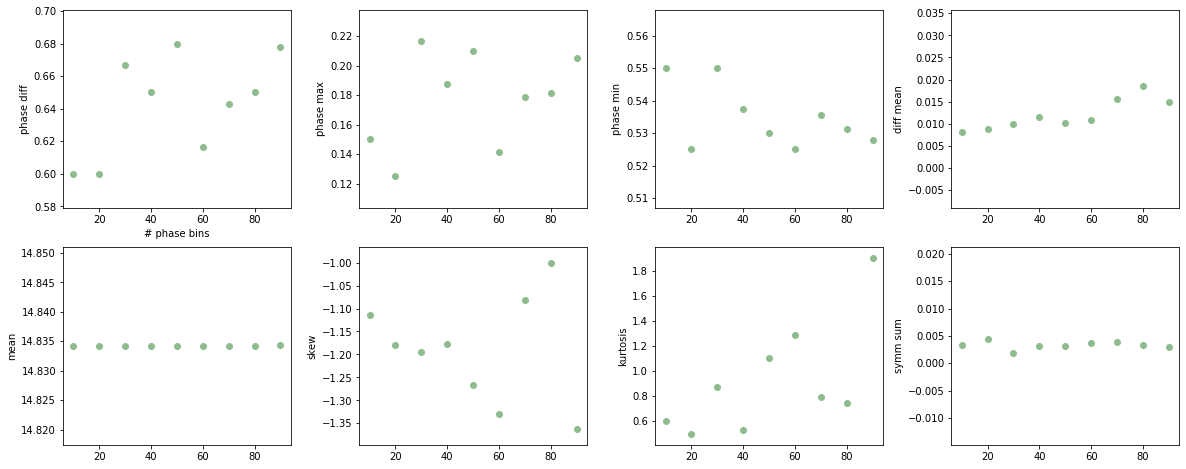

In [15]:
bindf = test_bins(iband17,bp17)

In [16]:
dict17

{'period': <Quantity 36.42639701>,
 'amp': 0.03030438044407724,
 'phase diff': 0.5625,
 'phase max': 0.09375,
 'phase min': 0.53125,
 'shape': 'not FRED',
 'diff mean': 0.00865141997997898,
 'mean': 14.834129014702366,
 'skew': -1.3242284673915747,
 'kurtosis': 1.113244785933814,
 'symm sum': 0.003981398481785549}

In [17]:
dict22

{'period': <Quantity 90.44088625>,
 'amp': 0.028003135485061392,
 'phase diff': 0.8333333333333334,
 'phase max': 0.9166666666666667,
 'phase min': 0.08333333333333334,
 'shape': 'FRED',
 'diff mean': 0.008419057402908218,
 'mean': 15.281258738002627,
 'skew': -1.07714645663876,
 'kurtosis': -0.3182155711411192,
 'symm sum': 0.008358182984879876}

# Combine Analysis and Do for Many Sources


In [18]:
def combine(srcn,pbins=16,det=True,window=200,btol=50,minp=5,maxp=100,testbins=True,retstep=False,close=False,mlist=['OII I','OIII I']):
    #LC, detrend, and spline search
    iband,vband,bp = o.splinesearch(srcn,cross,full,close=close,minp=minp,maxp=maxp,det=det,window=window,btol=btol,phase=True,color=pink,ylim=.08,mlist=mlist)
    #analyze phase-folded data with best period, yielding dictionary
    plot = not close
    mid,avg,err,pdict = phase_dict(iband,bp,pbins,det=det,retstep=True,plotsymm=plot,close=close)
    if testbins: bindf = test_bins(iband,bp)
    if retstep: return mid,avg,err,pdict
    else: return pdict

In [19]:
reload(o)
mid,avg,err,pdict = combine(17,close=True,testbins=False,retstep=True)

established period: 36.43182


In [20]:
pdict['period']

<Quantity 36.42639701>

# Run for Several Sources and Scatter Values
- few enough that correlations can be verified by eye


established period: 36.43182
established period: 90.5
established period: 75.97
established period: 22.5
established period: 137.36
empty file for OIII I
established period: 110.6
established period: 33.38
established period: 88.3
established period: 21.95


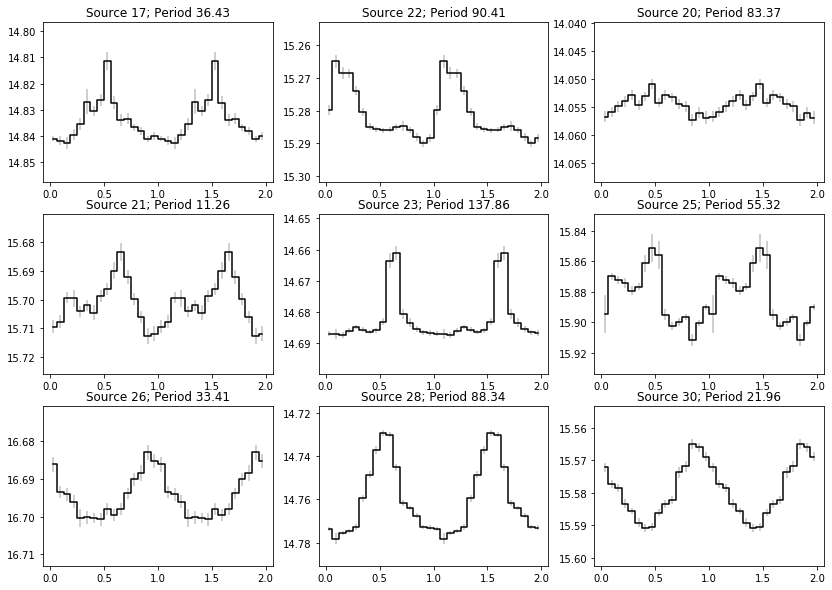

In [21]:
sdf = pd.DataFrame(columns=['source','amp','phase diff','phase max','phase min','shape',
                             'diff mean','mean','skew','kurtosis','symm sum','period'])
sources = [17,22,20,21,23,25,26,28,30]
sdf['source'] = sources
#subplots with all folds
allmids = []
allavgs = []
allerrs = []
for s in sources:
    mid,avg,err,tdict = combine(s,maxp=150,testbins=False,close=True,retstep=True)
    allmids.append(mid);allavgs.append(avg);allerrs.append(err)
    for d in list(tdict.keys()):
        row = sdf[sdf['source']==s]
        row[d] = tdict[d]
        sdf[sdf['source']==s] = row
c = 1
fig = plt.figure(figsize=(14,10))
#wasn't working in first loop b/c of plt.close 
for s in range(len(sources)):
    mid,avg,err = allmids[s],allavgs[s],allerrs[s]
    ax = fig.add_subplot(3,3,c)
    ax.step(mid,avg,where='mid',color='black')
    ax.errorbar(mid,avg,yerr=err,ls='none',color='grey',alpha=0.5)
    maxa,mina = np.max(avg)+np.max(err),np.min(avg)-np.max(err)
    ax.set_ylim(maxa+.01,mina-.01)
    #get source numbers and periods
    srcn = sdf.loc[s]['source']
    per = sdf.loc[s]['period']
    ax.set_title(f'Source {srcn}; Period {per:.2f}')
    c+=1


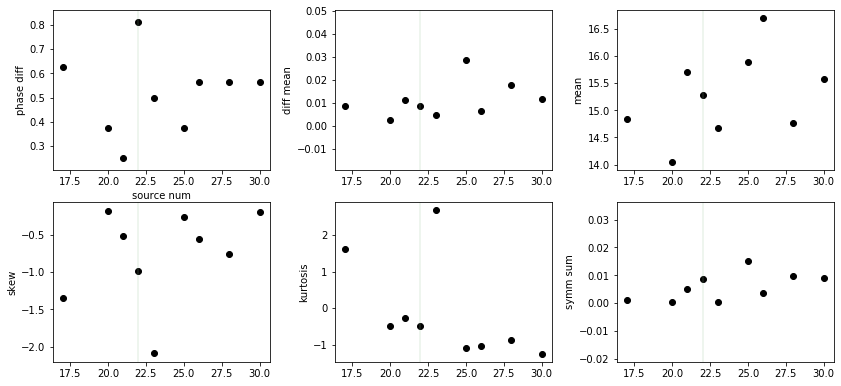

In [22]:
fig = plt.figure(figsize=(14,10))
c = 1
#phase min, phase max don't matter when comparing different sources
for r in ['phase diff','diff mean','mean','skew','kurtosis','symm sum']:
    ax = fig.add_subplot(3,3,c)
    ax.scatter(sdf['source'],sdf[r],color='black')
    ax.set_ylabel(r)
    if c==1:
        ax.set_xlabel('source num')
    c+=1
    ax.axvline(22,color='darkseagreen',alpha=0.2)
plt.subplots_adjust(wspace=0.3)

Text(0.5, 0, 'Source #')

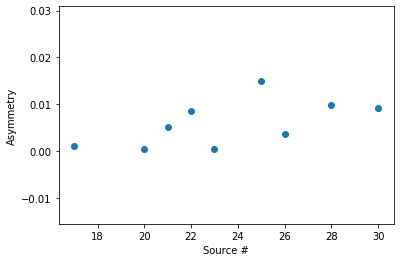

In [23]:
plt.scatter(sdf['source'],sdf['symm sum'])
# plt.ylim(-.002,.005)
plt.ylabel('Asymmetry')
plt.xlabel('Source #')

In [24]:
sdf #for this purpose, not yet important if "correct" period identified

,source,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,period
0,17,0.0315209,0.625,0.15625,0.53125,not FRED,0.00866886,14.8342,-1.35135,1.61062,0.00107911,36.4336
1,22,0.0250914,0.8125,0.90625,0.09375,FRED,0.00864448,15.2813,-0.984159,-0.478212,0.00851687,90.4115
2,20,0.00647905,0.375,0.84375,0.46875,not FRED,0.00280413,14.0546,-0.180608,-0.487617,0.000406812,83.3731
3,21,0.029119,0.25,0.90625,0.65625,not FRED,0.0115049,15.7011,-0.523324,-0.256615,0.00500751,11.2639
4,23,0.0261777,0.5,0.15625,0.65625,not FRED,0.00475577,14.6826,-2.08342,2.68109,0.000326683,137.856
5,25,0.060389,0.375,0.84375,0.46875,not FRED,0.0284811,15.8832,-0.26104,-1.0828,0.0149943,55.3154
6,26,0.0177288,0.5625,0.46875,0.90625,not FRED,0.00650676,16.6942,-0.555024,-1.04219,0.003578,33.409
7,28,0.0490108,0.5625,0.09375,0.53125,not FRED,0.0180275,14.7602,-0.761552,-0.871156,0.00990325,88.3416
8,30,0.025821,0.5625,0.40625,0.84375,not FRED,0.0117473,15.5791,-0.204906,-1.24267,0.00913918,21.9552


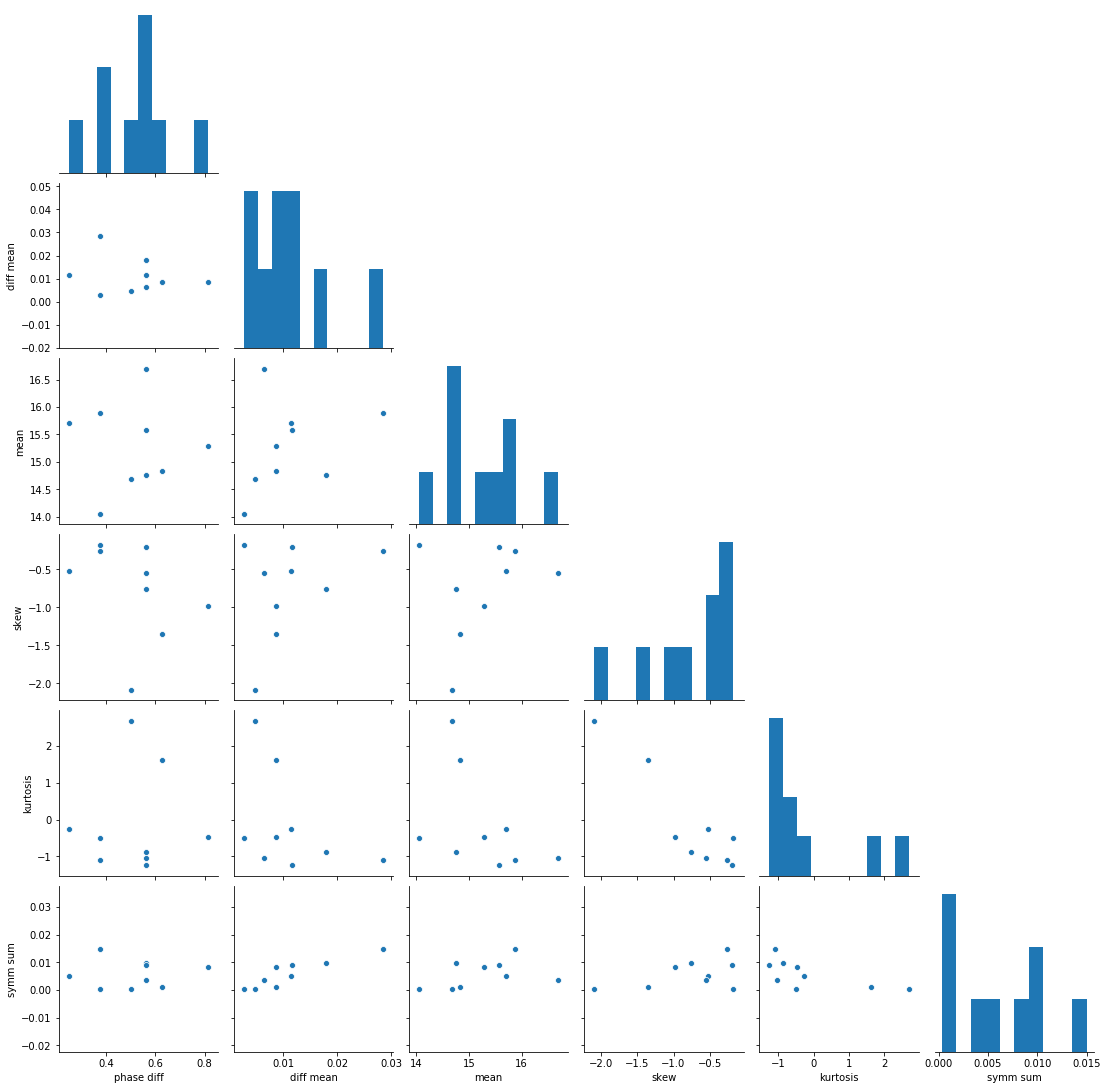

In [25]:
#corner plot
c = sb.pairplot(sdf,vars=['phase diff','diff mean','mean','skew','kurtosis','symm sum'],corner=True)
# plt.savefig('Figs/cornerplot.png',dpi=200,bbox_inches='tight')


add mean standard error

# repeat with many more sources

In [26]:
summ[:5]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
0,1,19.271511,-73.443405,0.717,0.5,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,NaN
1,2,20.418930,-72.959070,2.165,2.0,84.000,2.147143,NaN,14.379506,0.356251,...,no,NaN,revisit alias and 6.8,0.768988,-1.033376,-1.537777,1.704585,83.985070,1.0,0.5845
2,3,13.639167,-73.683640,2.370,0.8,18.380,0.259701,NaN,14.877813,0.267369,...,yes,NaN,~1 day error on pd,1.698965,2.086592,1.458121,0.808846,17.404354,1.0,0.2325
3,4,14.797429,-71.645960,2.763,7.5,82.370,0.000000,NaN,13.919472,0.042264,...,yes,0.030,possible drift,1.061946,0.298944,0.799828,1.009136,81.891818,1.0,0.0510
4,5,12.913330,-72.284330,4.780,1.4,0.000,0.000000,NaN,15.549296,0.044747,...,no,0.133,"0.39,9.5,50.5,70.3 other possible",-0.257503,1.181314,-0.241179,0.598523,2.233790,1.0,0.0420


In [27]:
p1 = summ[summ['Part']==1]
p2 = summ[summ['Part']==2]
p1nums = p1['src_n']
p2nums = p2['src_n']

In [28]:
p1nums = p1nums[p1nums!=51] #.dat tables that are read in as strings

In [29]:
p1 = p1[p1['src_n']!=51]

In [30]:
p1f = pd.DataFrame(columns=['source','amp','phase diff','phase max','phase min','shape',
                             'diff mean','mean','skew','kurtosis','symm sum','period'])
sources = p1nums
p1f['source'] = sources
#subplots with all folds
# allmids = []
# allavgs = []
# allerrs = []
for s in sources:
    det = True
    #change max period if est. period high
    maxp = 150
    minp = 10
    estp = float(summ[summ['src_n']==s]['est. period'])
    if estp > 150:
        maxp = estp + 30
        minp = estp - 30
    if estp > 300:
        det = False
        print('searching without detrending')
        print(det)
    mid,avg,err,tdict = combine(s,minp=minp,maxp=maxp,det=det,testbins=False,close=True,retstep=True)
#     allmids.append(mid);allavgs.append(avg);allerrs.append(err)
    for d in list(tdict.keys()):
        row = p1f[p1f['source']==s]
        row[d] = tdict[d]
        p1f[p1f['source']==s] = row

established period: 84.0
established period: 18.38
established period: 82.37
established period: nan
established period: 17.2
established period: 21.9
established period: 44.92
established period: 40.03
established period: 28.51
established period: 77.2
established period: 36.3
established period: 35.6
established period: nan
established period: 74.51
established period: 36.43182
established period: 75.97
established period: 22.5
established period: 90.5
established period: 137.36
established period: 62.1
empty file for OIII I
established period: 110.6
established period: 33.38
searching without detrending
False
established period: 362.3
established period: 88.3
established period: 21.95
established period: 103.6
established period: 197.0
established period: nan
established period: nan
established period: 68.54
established period: 67.88
established period: nan
established period: 71.98
established period: 224.0
established period: 29.91
established period: 64.8
established period: 59.7

In [31]:
p1f[:10]

,source,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,period
1,2,0.0154438,0.375,0.84375,0.46875,not FRED,0.00676558,14.3768,-0.319695,-0.732703,0.00348581,83.9787
2,3,0.0213425,0.75,0.15625,0.40625,not FRED,0.0110472,14.8748,0.207782,-1.42412,0.00794393,127.043
3,4,0.0115643,0.5625,0.34375,0.78125,not FRED,0.00428614,13.9187,-0.634903,-1.04576,0.00155964,81.9124
4,5,0.0117298,0.6875,0.65625,0.96875,not FRED,0.00497352,15.5478,-0.158475,-0.487782,2.83888e-05,11.7689
5,6,0.0114309,0.4375,0.78125,0.34375,not FRED,0.00665081,15.9024,0.316398,-1.33019,0.000509471,17.3463
6,7,0.0213845,0.3125,0.78125,0.46875,not FRED,0.00917522,14.7188,-0.419122,-1.22597,0.00179027,108.579
8,9,0.0355826,0.5625,0.65625,0.09375,FRED,0.0126478,14.7627,-0.856967,-0.460656,0.00476424,44.9093
9,10,0.0279687,0.5625,0.46875,0.90625,not FRED,0.0123861,15.861,-0.396718,0.178433,0.00613706,39.8247
10,11,0.0130793,0.4375,0.65625,0.21875,not FRED,0.00610179,14.7698,-0.158737,-1.22237,0.000152641,112.283
11,12,0.00847238,0.5625,0.28125,0.71875,not FRED,0.00394018,16.2283,-0.193304,-0.922564,0.00232276,20.0966


In [32]:
p1f['spin period'] = p1['spin period']

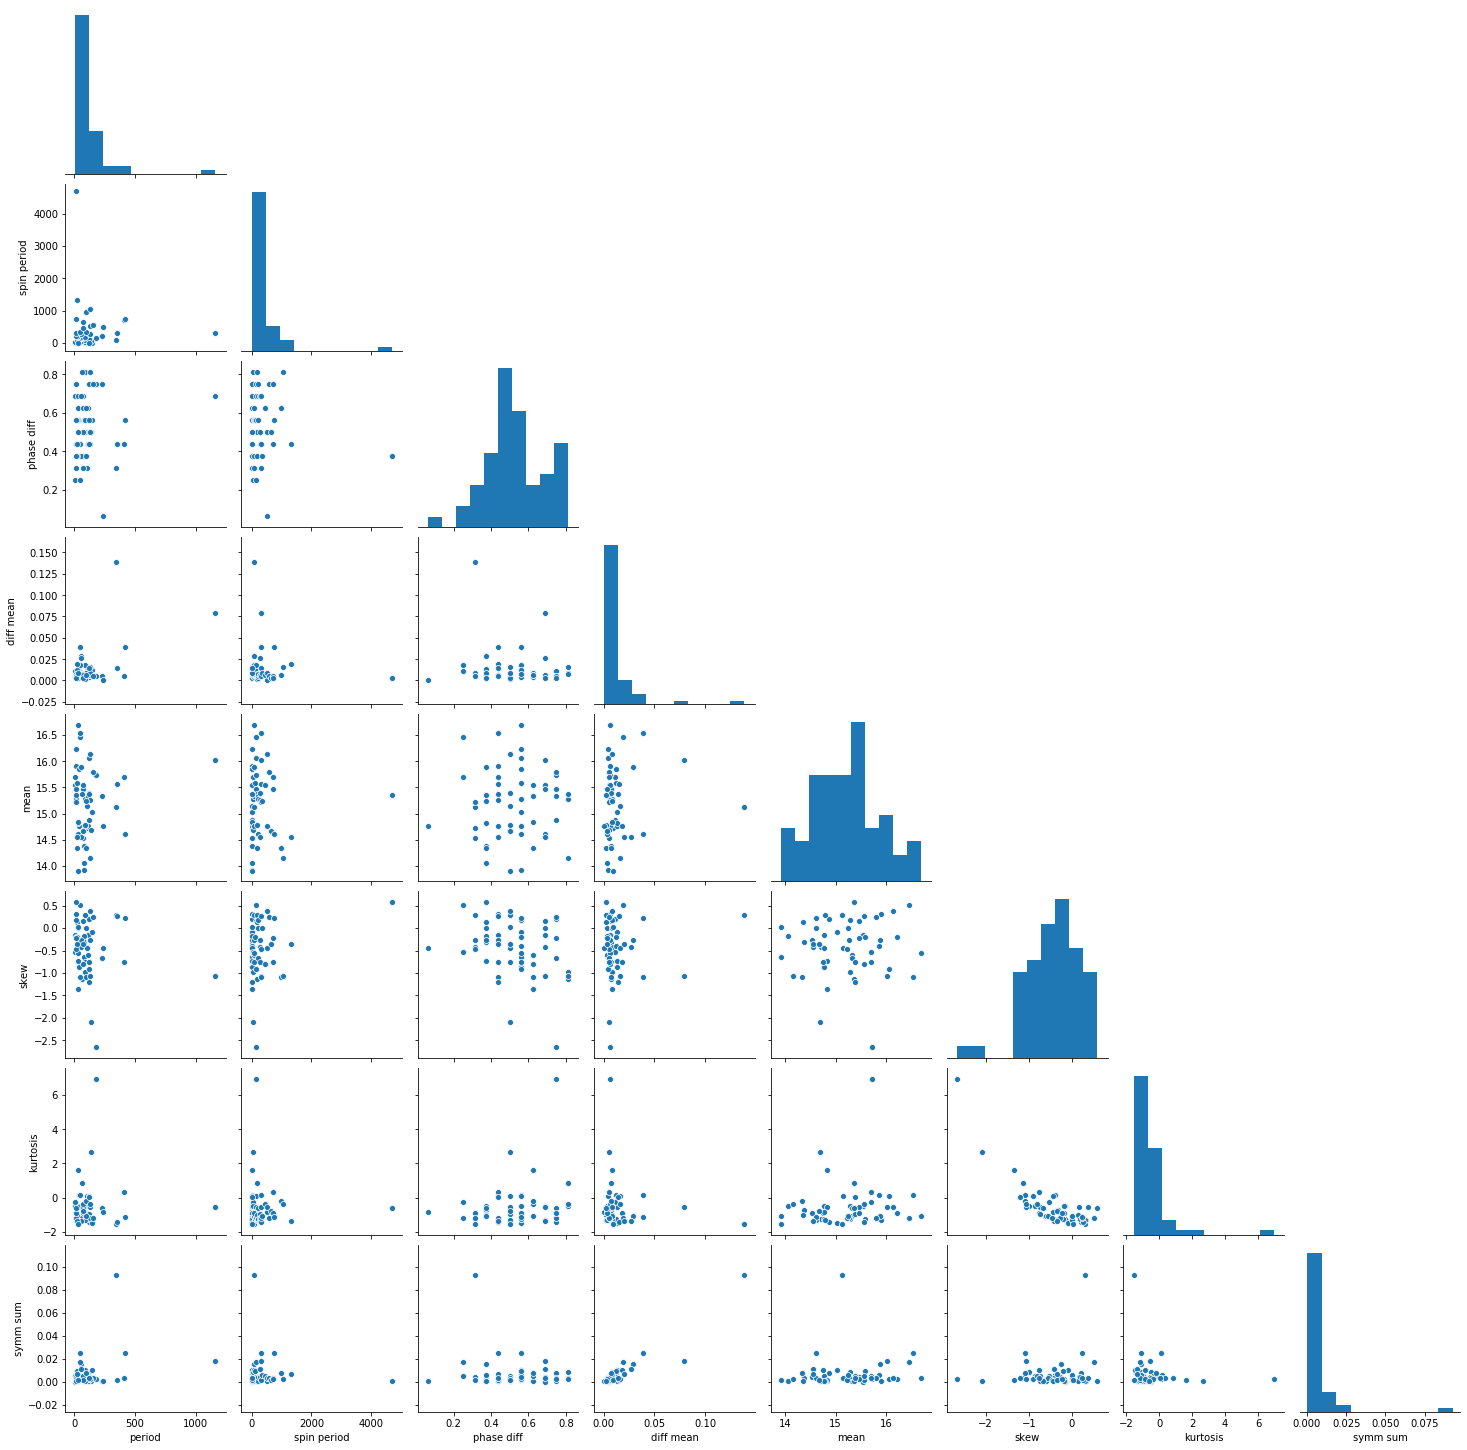

In [33]:
#corner plot with all part 1 sources
c = sb.pairplot(p1f,vars=['period','spin period','phase diff','diff mean','mean','skew','kurtosis','symm sum'],corner=True)

#### may want to get rid of the correlation between symm sum (average difference between bins folded over peak) and mean
- difference can tend to be higher if the values span a larger range

In [34]:
cross2 = Table.read('part2files.csv')
cross = join(cross2,full,keys='src_n')

In [35]:
p2nums = p2nums[p2nums!=1]

In [36]:
# repeat with part 2 sources
# then add to same df and make corner plot with comparison
reload(o)
p2f = pd.DataFrame(columns=['source','amp','phase diff','phase max','phase min','shape',
                             'diff mean','mean','skew','kurtosis','symm sum','period'])
sources = p2nums
p2f['source'] = sources
#subplots with all folds
# allmids = []
# allavgs = []
# allerrs = []
for s in sources:
    det = True
    #change max period if est. period high
    maxp = 150
    minp = 10
    estp = float(summ[summ['src_n']==s]['est. period'])
    if estp > 150:
        maxp = estp + 30
        minp = estp - 30
    if estp > 300:
        det = False
        print('searching without detrending')
        print(det)
    mid,avg,err,tdict = combine(s,minp=minp,maxp=maxp,det=det,testbins=False,close=True,retstep=True,mlist=['OII I','OIII I','OIV I'])
#     allmids.append(mid);allavgs.append(avg);allerrs.append(err)
    for d in list(tdict.keys()):
        row = p2f[p2f['source']==s]
        row[d] = tdict[d]
        p2f[p2f['source']==s] = row

established period: nan
established period: 17.79
established period: 49.06
established period: 91.5
established period: nan
established period: nan
established period: nan
established period: nan
searching without detrending
False
established period: 414.91345
established period: nan
established period: 80.1
established period: nan
established period: nan
empty file for OII I
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
established period: nan
empty file for OIII I
established period: nan
established period: nan
established period: nan
established period: 72.231
established period: nan
established period:

In [37]:
p1f['Part'] = 1
p2f['Part'] = 2

In [38]:
alldf = pd.concat([p1f,p2f])

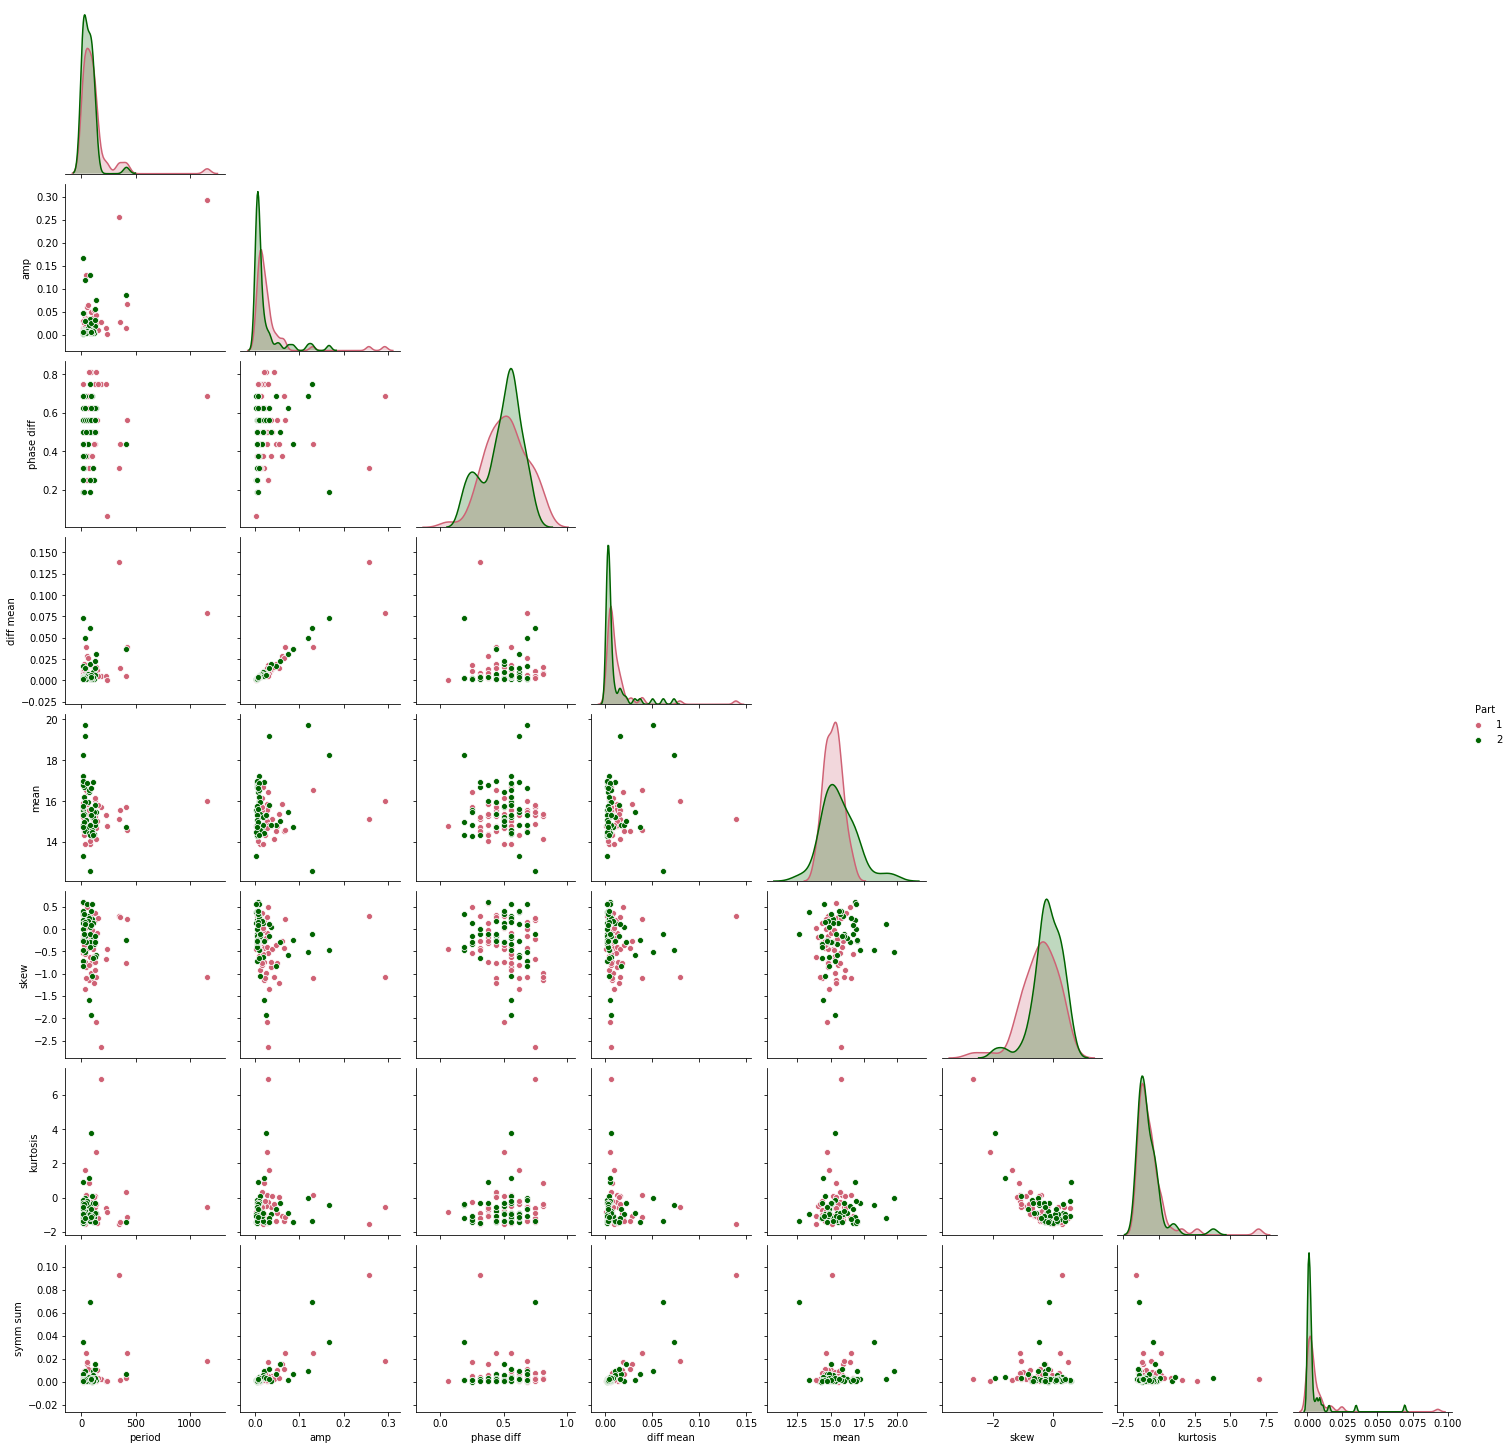

In [39]:
c = sb.pairplot(alldf,vars=['period','amp','phase diff','diff mean','mean','skew','kurtosis','symm sum'],corner=True,hue='Part',palette=[pink,'darkgreen'])

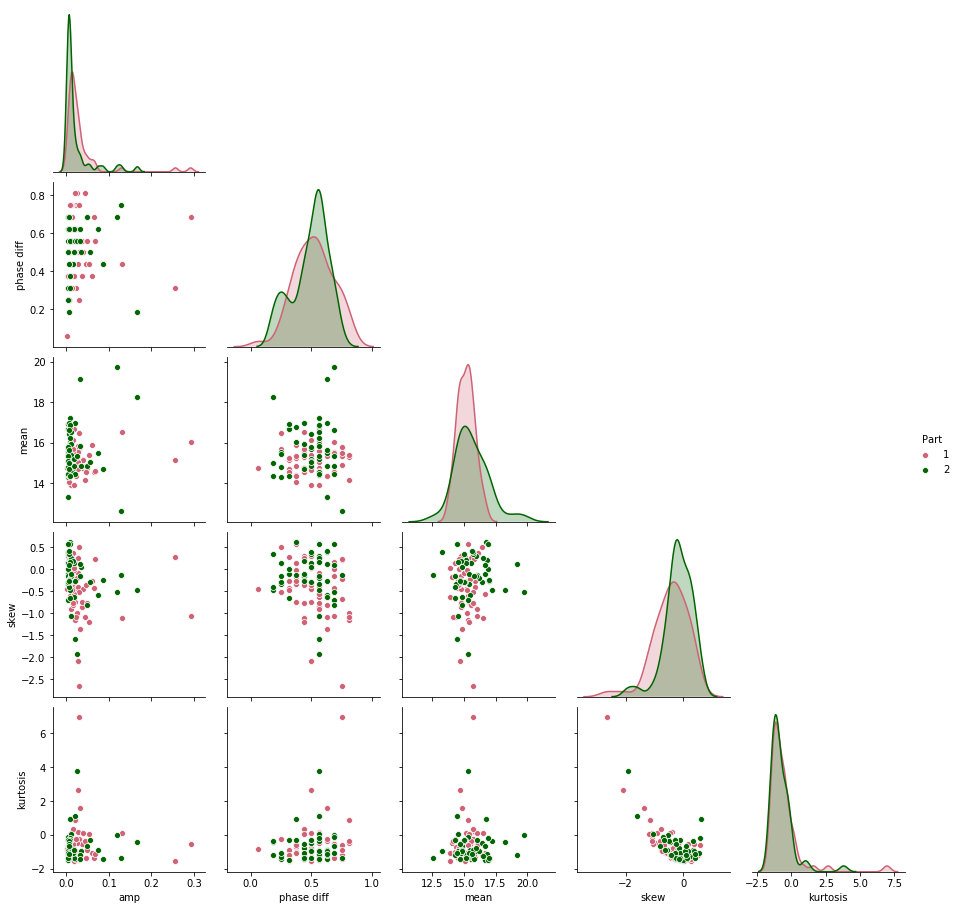

In [40]:
#simplify
c = sb.pairplot(alldf,vars=['amp','phase diff','mean','skew','kurtosis'],corner=True,hue='Part',palette=[pink,'darkgreen'])